# CSE3013 J Component
# Detection and Recognition of Sign Language
### Soham Bhattacharyya (19BCE1199)
### Riddhirup Bera (19BCE1169)
### Pranjal Singh (19BCE1207)
### Avihrik Basak (19BCE1202)
### Pranish Shrestha (19BCE1758)

In [1]:
#works with tensorflow 2.3.0 if keras libraries are imported directly
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, Adagrad # 3 most popular gradient descent functions
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import re
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [2]:
# Code for Enter key: 13
# Code for Nothing: 255
# Code for Escape: 27

import winsound
frequency = 300  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second

background = None
alpha = 0.5 
'''A lower value for this variable means 
running average will be performed over a larger amount of 
previous frames and vice-versa.'''


#ROI: Region of interest
ROI = {'top':100,'bottom':300,'right':150,'left':350}

In [3]:
def calc_background(frame, alpha):

    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None
    
    '''The objective is to detect active objects from the difference obtained from 
    the reference frame and the current frame (background). We keep feeding each frame to the accumulateWeighted() function,
    and the function keeps finding the averages of all frames. '''
    
    cv2.accumulateWeighted(frame, background, alpha)

In [4]:
def detect_hand(frame, threshold=25):
    global background
    
    #absolute difference between hand frame and background frame
    abdiff = cv2.absdiff(frame, background.astype("uint8")) 
    cv2.imshow("Difference", abdiff)
    
    _ , thresholded = cv2.threshold(abdiff, threshold, 255, cv2.THRESH_BINARY) #if pixel value >threshold, 
    #255 else 0 (Binary thresholding)

    # detects change in the image color and marks it as contour. Detection of hand in front of the background
    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
    # hierarchy: contains information about image topology; number of elements equal to number of contours

    if len(contours) == 0:
        return None
    else:
        #sorts by contour area and finds contour with maximum area
        hand_segment_max_cont = max(contours, key=cv2.contourArea) 
        
        return (thresholded, hand_segment_max_cont)

### Collecting images for dataset

In [9]:
element = 0 #initialising the element variable where the gesture label will be stored
cam = cv2.VideoCapture(0)
while True:
    
    ret, frame = cam.read()

    # flipping the frame to prevent inverted image of captured frame
    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()
    cv2.putText(frame_copy, "Enter next choice of character", (0, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    cv2.putText(frame_copy, "Press Escape to exit", (0, 450), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    cv2.imshow("Sign Language Image Data Collector", frame_copy)
    num_frames = 0
    ele0 = cv2.waitKey(1) & 0xFF
    if ele0==27: #break loop for escape
        print("breaking loop")
        break
    element = chr(ele0)
    #element = 'A'
    num_imgs_taken = 0
    print(chr(ele0)) if ele0!=255 else print(end="")
    while ele0!=255 and ele0!=13:
        ret, frame = cam.read()

        # flipping the frame to prevent inverted image of captured frame
        frame = cv2.flip(frame, 1)

        frame_copy = frame.copy()

        roi = frame[ROI['top']:ROI['bottom'], ROI['right']:ROI['left']]

        gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

        if num_frames < 60:
            calc_background(gray_frame, alpha)
            cv2.putText(frame_copy, "Wait while background is being recorded", (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
            
        # Placing the hand in the Region of Interest (adjustment allowed till 300 frames)
        elif num_frames <= 300: 

            hand = detect_hand(gray_frame)
            
            cv2.putText(frame_copy, "Make gesture for '"+str(element)+"'", (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            # Checking if hand is actually detected by counting number of contours detected
            if hand is not None:
                
                thresholded, hand_segment = hand

                # Draw contours around hand segment
                cv2.drawContours(frame_copy, [hand_segment + (ROI['right'], ROI['top'])], -1, (255, 0, 0),1)
                
                cv2.putText(frame_copy, str(num_frames)+" for " + str(element), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

                # Also display the thresholded image
                cv2.imshow("Thresholded Hand Image", thresholded)
        
        else: 
            
            # Detecting contours in the hand
            hand = detect_hand(gray_frame)
            # Checking for hand
            if hand is not None:
                
                # unpack the thresholded img and the max_contour
                thresholded, hand_segment = hand

                # Drawing contours around hand segment
                cv2.drawContours(frame_copy, [hand_segment + (ROI['right'], ROI['top'])], -1, (255, 0, 0),1)
                
                
                cv2.putText(frame_copy, str(num_imgs_taken) + ' images for' + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
                
                # Displaying the thresholded image
                cv2.imshow("Thresholded Hand Image", thresholded)
                if num_imgs_taken <= 500:
                    cv2.putText(frame_copy, 'Collected '+str(num_imgs_taken)+' training images for' + str(element), (0, 450), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
#                     Path("data2/train/"+str(element)+"/").mkdir(parents=True, exist_ok=True)
#                     printed = cv2.imwrite(r"data2/train/"+str(element)+"/"+str(num_imgs_taken) + '.jpg', thresholded)
#                     print(printed," img: ",num_imgs_taken ) if not printed else print(end="")
                    pass
                elif num_imgs_taken<=600:
                    cv2.putText(frame_copy, 'Collected '+str(num_imgs_taken)+' testing images for' + str(element), (0, 450), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
#                     Path("data2/test/"+str(element)+"/").mkdir(parents=True, exist_ok=True)
#                     printed = cv2.imwrite(r"data2/test/"+str(element)+"/"+str(num_imgs_taken) + '.jpg', thresholded)
#                     print(printed," img: ",num_imgs_taken ) if not printed else print(end="")
                    pass
                else:
                    break
                num_imgs_taken+=1
            else:
                cv2.putText(frame_copy, 'No hand detected...', (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

        # Drawing ROI on frame copy
        cv2.rectangle(frame_copy, (ROI['left'], ROI['top']), (ROI['right'], ROI['bottom']), (0,255,168), 3)
        
        cv2.putText(frame_copy, "CSE3013 J Component - Sign Language Detection & Recognition", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
        
        # increment the number of frames for tracking
        num_frames += 1

        # Display the frame with segmented hand
        cv2.imshow("Sign Language Image Data Collector", frame_copy)

        # Closing windows with Escape key
        k = cv2.waitKey(1) & 0xFF
        if k == 27:
            break
    

    #f = False
# Releasing camera & destroying all the windows...
cv2.destroyAllWindows()
cam.release()

A
B
breaking loop


### Training CNN with 64 * 64 images

In [2]:
train_path = r'data\train'
test_path = r'data\test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(64,64), class_mode='categorical', batch_size=5,shuffle=True)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(64,64), class_mode='categorical', batch_size=5, shuffle=True)

imgs, labels = next(train_batches) # returns the next 5 images in the shuffled training dataset

Found 12024 images belonging to 24 classes.
Found 2400 images belonging to 24 classes.


5
64
64
3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


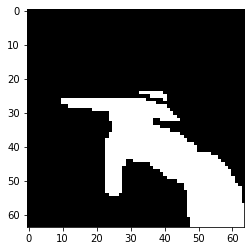

24 classes


In [3]:
import matplotlib.pyplot as plt
x = imgs
for i in range(imgs.ndim):
    print(len(x))
    x = x[0]
x = imgs[0]
fig, ax = plt.subplots()
img = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
ax.imshow(img)
plt.show()
print(len(labels[0]),"classes")
classes = len(labels[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


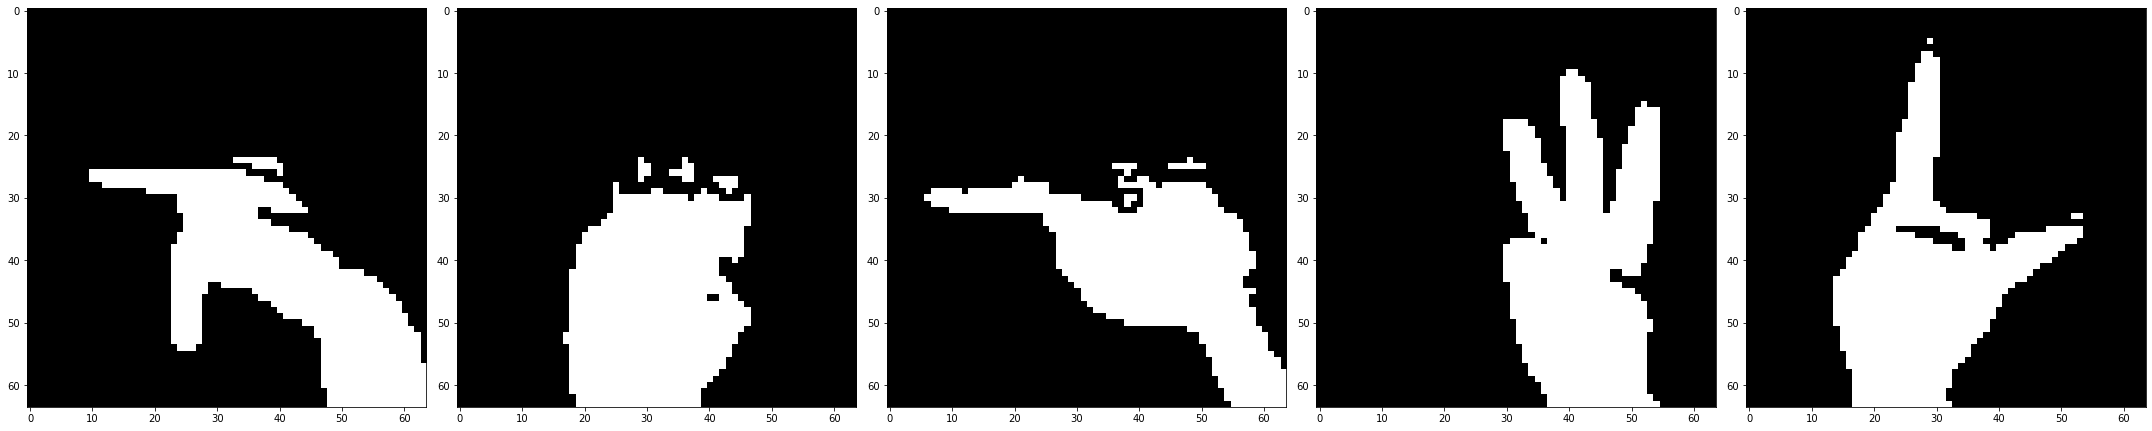

(5, 64, 64, 3)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [4]:
#Plotting the images
classes = len(labels[0])
def showBatch1(arr):
    fig, axes = plt.subplots(1, 5, figsize=(30,20))
    axes = axes.flatten()
    for img, ax in zip( arr, axes):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


showBatch1(imgs)
print(imgs.shape)
print(labels)

In [4]:
model = Sequential() #initialising a sequential model to store layers of tensors

'''Keras Conv2D is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input 
which helps produce a tensor of outputs.

Kernel: In image processing kernel is a convolution matrix or a mask which can be used for blurring, 
sharpening, embossing, edge detection, and more by doing a convolution between a kernel and an image.'''

model.add(Conv2D(activation='relu', input_shape=(64,64,3), filters=32, kernel_size=(3, 3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(activation='relu', padding = 'same',filters=64, kernel_size=(3, 3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(activation='relu', padding = 'valid',filters=128, kernel_size=(3, 3) ))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.2))
model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.3))
model.add(Dense(24,activation ="softmax"))

#### Adam gradient descent

Validation accuracy: 96.42%
6 epochs

In [10]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

history2 = model.fit(train_batches, epochs=6, callbacks=[reduce_lr, early_stop],  validation_data = test_batches)#, checkpoint])
imgs, labels = next(train_batches) # For getting next batch of imgs...

imgs, labels = next(test_batches) # For getting next batch of imgs...
scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')


Epoch 1/6
1203/1203 [==============================] - 326s 271ms/step - loss: 0.2218 - accuracy: 0.9618 - val_loss: 0.3758 - val_accuracy: 0.9371
Epoch 2/6
1203/1203 [==============================] - 65s 54ms/step - loss: 0.0878 - accuracy: 0.9837 - val_loss: 0.7718 - val_accuracy: 0.9125
Epoch 3/6
1203/1203 [==============================] - 70s 58ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.1368 - val_accuracy: 0.9567
Epoch 4/6
1203/1203 [==============================] - 70s 58ms/step - loss: 4.4047e-04 - accuracy: 1.0000 - val_loss: 0.1337 - val_accuracy: 0.9621
Epoch 5/6
1203/1203 [==============================] - 73s 61ms/step - loss: 3.2032e-04 - accuracy: 1.0000 - val_loss: 0.1273 - val_accuracy: 0.9658
Epoch 6/6
1203/1203 [==============================] - 68s 56ms/step - loss: 6.3842e-05 - accuracy: 1.0000 - val_loss: 0.1281 - val_accuracy: 0.9642
loss of 0.0025481190532445908; accuracy of 100.0%


#### SGD gradient descent

Validation accuracy: 96.71%, 3 epochs

In [12]:
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


history2 = model.fit(train_batches, epochs=6, callbacks=[reduce_lr, early_stop],  validation_data = test_batches)#, checkpoint])
imgs, labels = next(train_batches) # For getting next batch of imgs...

imgs, labels = next(test_batches) # For getting next batch of imgs...
scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

Epoch 1/6
1203/1203 [==============================] - 63s 52ms/step - loss: 0.3119 - accuracy: 0.9384 - val_loss: 0.0695 - val_accuracy: 0.9729
Epoch 2/6
1203/1203 [==============================] - 67s 56ms/step - loss: 0.0024 - accuracy: 0.9998 - val_loss: 0.0956 - val_accuracy: 0.9658
Epoch 3/6
1203/1203 [==============================] - 67s 56ms/step - loss: 9.5415e-04 - accuracy: 1.0000 - val_loss: 0.0973 - val_accuracy: 0.9671
loss of 0.0018245566170662642; accuracy of 100.0%


#### Adagrad gradient descent

Validation accuracy: 95.79%, 6 epochs

In [15]:
from keras.optimizers import Adagrad
model1 = tf.keras.models.clone_model(
    model, input_tensors=None, clone_function=None
)
model1.compile(optimizer=Adagrad(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


history2 = model1.fit(train_batches, epochs=6, callbacks=[reduce_lr, early_stop],  validation_data = test_batches)#, checkpoint])
imgs, labels = next(train_batches) # For getting next batch of imgs...

imgs, labels = next(test_batches) # For getting next batch of imgs...
scores = model1.evaluate(imgs, labels, verbose=0)
print(f'{model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')

Epoch 1/6
1203/1203 [==============================] - 61s 51ms/step - loss: 0.2836 - accuracy: 0.9456 - val_loss: 0.1660 - val_accuracy: 0.9538
Epoch 2/6
1203/1203 [==============================] - 66s 55ms/step - loss: 0.0048 - accuracy: 0.9993 - val_loss: 0.1503 - val_accuracy: 0.9513
Epoch 3/6
1203/1203 [==============================] - 66s 55ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.1345 - val_accuracy: 0.9571
Epoch 4/6
1203/1203 [==============================] - 66s 55ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1277 - val_accuracy: 0.9571
Epoch 5/6
1203/1203 [==============================] - 66s 55ms/step - loss: 8.2463e-04 - accuracy: 1.0000 - val_loss: 0.1243 - val_accuracy: 0.9583
Epoch 6/6
1203/1203 [==============================] - 67s 55ms/step - loss: 6.2254e-04 - accuracy: 1.0000 - val_loss: 0.1265 - val_accuracy: 0.9579
loss of 0.0007578865042887628; accuracy of 100.0%


#### SGD gradient descent 
Validation accuracy: 94.29%, 5 epochs

In [5]:
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


history2 = model.fit(train_batches, epochs=10, callbacks=[reduce_lr, early_stop],  validation_data = test_batches)#, checkpoint])
imgs, labels = next(train_batches) # For getting next batch of imgs...

imgs, labels = next(test_batches) # For getting next batch of imgs...
scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

Epoch 1/10
1203/1203 [==============================] - 343s 285ms/step - loss: 0.3556 - accuracy: 0.9120 - val_loss: 0.2789 - val_accuracy: 0.9388
Epoch 2/10
1203/1203 [==============================] - 66s 55ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2649 - val_accuracy: 0.9429
Epoch 3/10
1203/1203 [==============================] - 68s 56ms/step - loss: 6.0521e-04 - accuracy: 1.0000 - val_loss: 0.2620 - val_accuracy: 0.9429
Epoch 4/10
1203/1203 [==============================] - 73s 61ms/step - loss: 3.9687e-04 - accuracy: 1.0000 - val_loss: 0.2694 - val_accuracy: 0.9421
Epoch 5/10
1203/1203 [==============================] - 76s 63ms/step - loss: 3.0564e-04 - accuracy: 1.0000 - val_loss: 0.2663 - val_accuracy: 0.9429
loss of 0.02056077867746353; accuracy of 100.0%


In [6]:
#model.save('cse4020_CNN.h5')

### Training CNN with 128 * 128 pixel images 

In [19]:
train_path1 = r'data2\train'
test_path1 = r'data2\test'
train_batches1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path1, target_size=(128,128), class_mode='categorical', batch_size=10,shuffle=True)
test_batches1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path1, target_size=(128,128), class_mode='categorical', batch_size=10, shuffle=True)
imgs1, labels1 = next(train_batches1) # returns the next 5 images in the shuffled training dataset

Found 12024 images belonging to 24 classes.
Found 2400 images belonging to 24 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


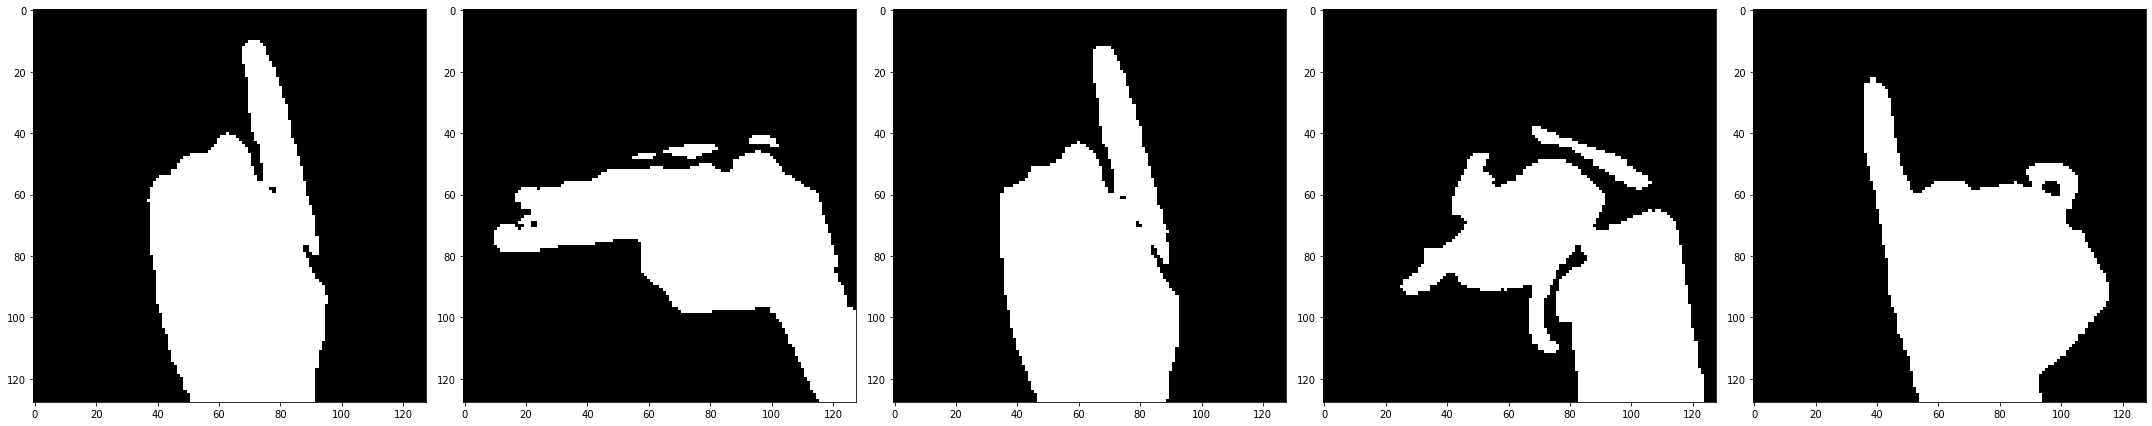

(10, 128, 128, 3)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [69]:
showBatch1(imgs1)
print(imgs1.shape)
print(labels1[0:5])

In [21]:
modelx = Sequential() #initialising a sequential model to store layers of tensors

'''Keras Conv2D is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input 
which helps produce a tensor of outputs.

Kernel: In image processing kernel is a convolution matrix or a mask which can be used for blurring, 
sharpening, embossing, edge detection, and more by doing a convolution between a kernel and an image.'''

modelx.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(128,128,3)))
modelx.add(MaxPool2D(pool_size=(2, 2), strides=2))
modelx.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'))
modelx.add(MaxPool2D(pool_size=(2, 2), strides=2))
modelx.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'valid'))
modelx.add(MaxPool2D(pool_size=(2, 2), strides=2))
modelx.add(Flatten())
modelx.add(Dense(128,activation ="relu"))
modelx.add(Dense(256,activation ="relu"))
modelx.add(Dense(256,activation ="relu"))
modelx.add(Dense(classes,activation ="softmax"))

#### SGD Gradient Descent
Validation accuracy: 96.96%, 3 epochs

In [22]:
modelx.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


history2 = modelx.fit(train_batches1, epochs=3, callbacks=[reduce_lr, early_stop],  validation_data = test_batches1)#, checkpoint])
imgs1, labels1 = next(train_batches1) # For getting next batch of train images

imgs1, labels1 = next(test_batches1) # For getting next batch of test images
scores = modelx.evaluate(imgs1, labels1, verbose=0)
print(f'{modelx.metrics_names[0]} of {scores[0]}; {modelx.metrics_names[1]} of {scores[1]*100}%')

Epoch 1/3
1203/1203 [==============================] - 818s 680ms/step - loss: 0.2421 - accuracy: 0.9705 - val_loss: 0.1099 - val_accuracy: 0.9692
Epoch 2/3
1203/1203 [==============================] - 808s 672ms/step - loss: 6.6163e-04 - accuracy: 1.0000 - val_loss: 0.1030 - val_accuracy: 0.9704
Epoch 3/3
1203/1203 [==============================] - 732s 609ms/step - loss: 3.2849e-04 - accuracy: 1.0000 - val_loss: 0.1025 - val_accuracy: 0.9696
loss of 0.00673780869692564; accuracy of 100.0%


In [24]:
modelx.save('cse3013_CNN2.h5')

In [25]:
modelx.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 63, 63, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 256)       295168    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)            

### Recording a key with sign language

In [5]:
class_names = [x[0][-1] if x[0][-2]=='\\' else '' for x in os.walk('data2/train')][1:]
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


In [6]:
model = keras.models.load_model(r"cse3013_CNN2.h5")

In [10]:
print('Instructions')
print("""
1. To start storing new key, press 1
    a) Let the camera accumulate the background
    b) Make gesture
    c) Once content with the output, press Enter to append the predicted character to the key being built
    d) Repeat 'b' and 'c' to add more characters in the key
    e) To delete a character, press Backspace
    f) To store key thus formed, press Escape
Press enter to continue
""")
#1 if storing key
x = input()
string = ''
cam = cv2.VideoCapture(0)
num_frames =0
while True:
    ret, frame = cam.read()

    # filpping the frame to prevent inverted image of captured frame...
    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()

    # ROI from the frame
    roi = frame[ROI['top']:ROI['bottom'], ROI['right']:ROI['left']]

    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)
    cv2.putText(frame_copy, "CSE3013 J Component - Sign Language Detection & Recognition", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    cv2.imshow("Sign Detection", frame_copy)
    cv2.rectangle(frame_copy, (ROI['left'], ROI['top']), (ROI['right'], ROI['bottom']), (255,128,0), 3)
    
    ele0 = cv2.waitKey(1) & 0xFF
    if ele0==27: #break loop for escape
        print("breaking loop")
        break
    element = chr(ele0)
    #element = 'A'
    num_imgs_taken = 0
    #print(chr(ele0),ele0) if ele0!=255 else print(end="")
    while chr(ele0)=='1':
        ret, frame = cam.read()

        # filpping the frame to prevent inverted image of captured frame...
        frame = cv2.flip(frame, 1)

        frame_copy = frame.copy()

        # ROI from the frame
        roi = frame[ROI['top']:ROI['bottom'], ROI['right']:ROI['left']]

        gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)


        if num_frames < 70:

            calc_background(gray_frame, alpha)

            cv2.putText(frame_copy, "Wait while Background is being recorded", (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)

        else: 
            # segmenting the hand region
            hand = detect_hand(gray_frame)


            # Checking for hand
            if hand is not None:

                thresholded, hand_segment = hand

                # Drawing contours around hand segment
                cv2.drawContours(frame_copy, [hand_segment + (ROI['right'], ROI['top'])], -1, (255, 0, 0),1)

                cv2.imshow("Thresholded Hand Image", thresholded)

                thresholded = cv2.resize(thresholded, (128, 128))
                thresholded = cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB)
                thresholded = np.reshape(thresholded, (1,thresholded.shape[0],thresholded.shape[1],3))

                pred = model.predict(thresholded)
                cv2.putText(frame_copy, class_names[np.argmax(pred)], (170, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
                ele1=cv2.waitKey(1) & 0xFF
                if ele1==13: #enter key
                    string+=class_names[np.argmax(pred)]
                    #print("Enter",string)
                if ele1==8 and len(string)>=1: #backspace
                    string = string[:-1]
                    #print("Backspace",string)
                if ele1==27:
                    break
            if len(string)>0:
                cv2.putText(frame_copy, "Key: "+str('*'*(len(string)-1)+string[-1]), (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)

        # Draw ROI on frame_copy
        cv2.rectangle(frame_copy, (ROI['left'], ROI['top']), (ROI['right'], ROI['bottom']), (0,255,168), 3)
        
        # incrementing the number of frames for collecting background
        if num_frames<=70:
            num_frames += 1

        # Display the frame with detected hand
        cv2.putText(frame_copy, "CSE3013 J Component - Sign Language Detection & Recognition", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
        cv2.imshow("Sign Detection", frame_copy)


        # Close windows with Escape key
        k = cv2.waitKey(1) & 0xFF

        if k == 27:
            break
    if len(string)>0:
        #write to file
        cv2.putText(frame_copy, "Writing to file", (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
        time.sleep(1)
        file1 = open("key.txt", "w") 
        file1.write(string)
        file1.close()
        string=""
    background=None
    num_frames = 0
    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break

# Release the camera and destroy all the windows
cam.release()
cv2.destroyAllWindows()

Instructions

1. To start storing new key, press 1
    a) Let the camera accumulate the background
    b) Make gesture
    c) Once content with the output, press Enter to append the predicted character to the key being built
    d) Repeat 'b' and 'c' to add more characters in the key
    e) To delete a character, press Backspace
    f) To store key thus formed, press Escape
Press enter to continue


breaking loop


In [6]:
cam.release()
cv2.destroyAllWindows()